In [185]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
#from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *
from sklearn.decomposition import PCA
from scipy.stats.mstats import zscore # This is to standardized the parameters

from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D, Conv2D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.layers import Flatten
from keras.optimizers import Adam

%matplotlib inline
np.random.seed(1)

## 1. Load Data

In [186]:
import math as M
from matplotlib import mlab
from matplotlib.colors import Normalize
from obspy.imaging.cm import obspy_sequential
import matplotlib.pyplot as plt
from skimage.transform import resize
import scipy

def getSpectogram(data, samp_rate, per_lap=0.9, wlen=None, log=False,
                outfile=None, fmt=None, axes=None, dbscale=False,
                mult=8.0, zorder=None, title=None,
                show=True, sphinx=False, clip=[0.0, 1.0]):
    
    # enforce float for samp_rate
    samp_rate = float(samp_rate)

    # set wlen from samp_rate if not specified otherwise
    if not wlen:
        wlen = samp_rate / 100.

    npts = len(data)
    # nfft needs to be an integer, otherwise a deprecation will be raised
    # XXX add condition for too many windows => calculation takes for ever
    nfft = int(_nearest_pow_2(wlen * samp_rate))
    if nfft > npts:
        nfft = int(_nearest_pow_2(npts / 8.0))

    if mult is not None:
        mult = int(_nearest_pow_2(mult))
        mult = mult * nfft
    nlap = int(nfft * float(per_lap))

    data = data - data.mean()
    end = npts / samp_rate

    
    specgram, freq, time = mlab.specgram(data, Fs=samp_rate, NFFT=nfft,
                                         pad_to=mult, noverlap=nlap)
    # db scale and remove zero/offset for amplitude
    if dbscale:
        specgram = 10 * np.log10(specgram[1:, :])
    else:
        specgram = np.sqrt(specgram[1:, :])
    freq = freq[1:]

    vmin, vmax = clip
    if vmin < 0 or vmax > 1 or vmin >= vmax:
        msg = "Invalid parameters for clip option."
        raise ValueError(msg)
    _range = float(specgram.max() - specgram.min())
    vmin = specgram.min() + vmin * _range
    vmax = specgram.min() + vmax * _range
    norm = Normalize(vmin, vmax, clip=True)
    
    return freq,time,specgram


def _nearest_pow_2(x):
    """
    Find power of two nearest to x

    >>> _nearest_pow_2(3)
    2.0
    >>> _nearest_pow_2(15)
    16.0

    :type x: float
    :param x: Number
    :rtype: Int
    :return: Nearest power of 2 to x
    """
    a = M.pow(2, M.ceil(np.log2(x)))
    b = M.pow(2, M.floor(np.log2(x)))
    if abs(a - x) < abs(b - x):
        return a
    else:
        return b

(64, 128)
(10240, 771)
(771, 1)
[0]


C:\Users\jhpark3\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  del sys.path[0]


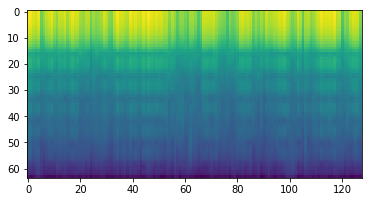

In [187]:
events = np.load("Datasets\DataDetection_M_2.8_R_0.5_S_4_Sec_256.npy")
label = np.load("Datasets\LabelDetection_M_2.8_R_0.5_S_4_Sec_256.npy")
times = np.load("Datasets/TimeDetection_M_2.8_R_0.5_S_4_Sec_256.npy") # features, # samples
times = (times - times[0,:]) * 3600 * 24 # set time to 0 and in seconds

fs = (times[:,0] < 60).nonzero()[0].shape[0] / 60 # sampling frequency
#fs=1
from scipy.signal import spectrogram

eventNumber = 600
freq , time, Sxx = getSpectogram(events[:,eventNumber], fs, dbscale = True)
#Sxx = scipy.misc.imresize(Sxx, [64, 64])
Sxx = scipy.misc.imresize(Sxx, [64, 128])
spectrogram_shape = Sxx.shape
print(spectrogram_shape)
print(events.shape)
print(label.shape)

plt.imshow(Sxx)
print(label[eventNumber])

In [188]:
print(times.shape)
print(fs)
print(times)

(10240, 771)
40.0
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.50048935e-02 2.49948353e-02 2.50048935e-02 ... 2.50048935e-02
  2.49948353e-02 2.50048935e-02]
 [5.00097871e-02 4.99997288e-02 4.99997288e-02 ... 4.99997288e-02
  4.99997288e-02 4.99997288e-02]
 ...
 [2.55925005e+02 2.55924995e+02 2.55925005e+02 ... 2.55925005e+02
  2.55924995e+02 2.55925005e+02]
 [2.55950010e+02 2.55950000e+02 2.55950000e+02 ... 2.55950000e+02
  2.55950000e+02 2.55950000e+02]
 [2.55975005e+02 2.55974995e+02 2.55975005e+02 ... 2.55975005e+02
  2.55974995e+02 2.55975005e+02]]


In [189]:
data = np.zeros((events.shape[1], spectrogram_shape[0], spectrogram_shape[1]))
for i in range(events.shape[1]):
    _, _, Sxx = getSpectogram(events[:,i], fs)
    Sxx = scipy.misc.imresize(Sxx, [64, 128])
    data[i, :, :] = (Sxx - np.mean(Sxx)) / np.std(Sxx)
    #data[i, :, :] = zscore(np.log10(Sxx))

data = data[:,:,:,np.newaxis] 

C:\Users\jhpark3\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


In [190]:
def split_reshape_dataset(X, Y, ratio):
    #X = X.T[:,:,np.newaxis, np.newaxis]
    #Y = Y.T
    m = X.shape[0] # number of samples
    sortInd = np.arange(m)
    np.random.shuffle(sortInd)
    nTrain = int(ratio * m)
    X_train = X[sortInd[:nTrain], :, :, :]
    Y_train = Y[sortInd[:nTrain],:]
    X_test = X[sortInd[nTrain:], :, :, :]
    Y_test = Y[sortInd[nTrain:],:]
    return X_train, X_test, Y_train, Y_test

#data = data[300:700,:]
#data = (data - np.mean(data, axis = 0, keepdims= True)) / np.std(data, axis = 0, keepdims = True)
#data=zscore(data)
RatioTraining=0.8; # 0.8 before
X_train, X_test, Y_train, Y_test = split_reshape_dataset(data, label, RatioTraining)
Y_train =convert_to_one_hot(Y_train,2).T
Y_test = convert_to_one_hot(Y_test,2).T

print(X_train.shape)
print(Y_train.shape)
print(data.shape)
print(label.shape)
i = 104

(616, 64, 128, 1)
(616, 2)
(771, 64, 128, 1)
(771, 1)


In [191]:
def model(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    
    X_input = Input(shape = input_shape)
    # keras.layers.Conv1D(filters, kernel_size, strides=1, padding='valid', data_format='channels_last', dilation_rate=1, activation=None, 
    
    # Step 1: CONV layer 
    X = Conv1D(filters=196,kernel_size=16,strides=4)(X_input) #None                                 # CONV1D
    X = BatchNormalization()(X) #None                                 # Batch normalization
    X = Activation(activation='relu')(X) #None                                 # ReLu activation
    X = Dropout(rate=0.8)(X) #None                                 # dropout (use 0.8)

    # Step 2: First GRU Layer 
    X = GRU(units=128, return_sequences=True)(X)#None                                 # GRU (use 128 units and return the sequences)
    X = Dropout(rate=.8)(X) #None                                 # dropout (use 0.8)
    X = BatchNormalization()(X) #None                                 # Batch normalization
    
    # Step 3: Second GRU Layer 
    X = GRU(units=128, return_sequences=True)(X) #None                                 # GRU (use 128 units and return the sequences)
    X = Dropout(rate=0.8)(X) #None                                 # dropout (use 0.8)
    X =  BatchNormalization()(X) #None                                 # Batch normalization
    X = Dropout(rate=0.8)(X) #None                                 # dropout (use 0.8)
    
    # Step 3: Second GRU Layer
    '''
    X = GRU(units=128, return_sequences=True)(X) #None                                 # GRU (use 128 units and return the sequences)
    X = Dropout(rate=0.8)(X) #None                                 # dropout (use 0.8)
    X =  BatchNormalization()(X) #None                                 # Batch normalization
    X = Dropout(rate=0.8)(X) #None   
    
    X = GRU(units=128, return_sequences=True)(X) #None                                 # GRU (use 128 units and return the sequences)
    X = Dropout(rate=0.8)(X) #None                                 # dropout (use 0.8)
    X =  BatchNormalization()(X) #None                                 # Batch normalization
    X = Dropout(rate=0.8)(X) #None   
    '''
    # Step 4: Time-distributed dense layer (≈1 line)
    
    
    
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) # time distributed  (sigmoid)
    X = Flatten()(X)
    X = Dense(1, activation = "sigmoid")(X) # time distributed  (sigmoid)
    ### END CODE HERE ###

    model = Model(inputs = X_input, outputs = X)
    
    
    return model  

In [192]:
Tx=2.5E-2
print(spectrogram_shape)
print(X_train.shape)
print(spectrogram_shape)
model = model(input_shape = (spectrogram_shape[0],spectrogram_shape[1]))
model.summary()

(64, 128)
(616, 64, 128, 1)
(64, 128)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 64, 128)           0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 13, 196)           401604    
_________________________________________________________________
batch_normalization_78 (Batc (None, 13, 196)           784       
_________________________________________________________________
activation_26 (Activation)   (None, 13, 196)           0         
_________________________________________________________________
dropout_105 (Dropout)        (None, 13, 196)           0         
_________________________________________________________________
gru_53 (GRU)                 (None, 13, 128)           124800    
_________________________________________________________________
dropout_106 (Dropout)        (None, 13

In [193]:
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])
#X_train_reshape=np.squeeze(X_train)
#X_train_reshape.shape
Y_train.shape
Y_train2=Y_train[:,0]
#Y_train2=Y_train2[:,np.newaxis,np.newaxis]
print(np.squeeze(X_train).shape)
print(Y_train2.shape)
model.fit(np.squeeze(X_train), Y_train2, batch_size = 10, epochs=100)


(616, 64, 128)
(616,)
Epoch 1/100
616/616 [==============================] - 7s 11ms/step - loss: 0.7809 - acc: 0.4903
Epoch 2/100
616/616 [==============================] - 2s 3ms/step - loss: 0.7275 - acc: 0.5081
Epoch 3/100
616/616 [==============================] - 2s 3ms/step - loss: 0.7391 - acc: 0.4432
Epoch 4/100
616/616 [==============================] - 2s 3ms/step - loss: 0.7281 - acc: 0.4984
Epoch 5/100
616/616 [==============================] - 2s 3ms/step - loss: 0.7349 - acc: 0.4838
Epoch 6/100
616/616 [==============================] - 2s 3ms/step - loss: 0.7182 - acc: 0.5000
Epoch 7/100
616/616 [==============================] - 2s 3ms/step - loss: 0.7113 - acc: 0.5244
Epoch 8/100
616/616 [==============================] - 2s 3ms/step - loss: 0.7069 - acc: 0.5000
Epoch 9/100
616/616 [==============================] - 2s 3ms/step - loss: 0.7280 - acc: 0.4740
Epoch 10/100
616/616 [==============================] - 2s 3ms/step - loss: 0.6971 - acc: 0.5422
Epoch 11/100
616

616/616 [==============================] - 2s 3ms/step - loss: 0.6912 - acc: 0.5471
Epoch 86/100
616/616 [==============================] - 2s 3ms/step - loss: 0.6994 - acc: 0.5227
Epoch 87/100
616/616 [==============================] - 2s 3ms/step - loss: 0.6957 - acc: 0.5438
Epoch 88/100
616/616 [==============================] - 2s 3ms/step - loss: 0.7023 - acc: 0.5292
Epoch 89/100
616/616 [==============================] - 2s 3ms/step - loss: 0.7002 - acc: 0.5130
Epoch 90/100
616/616 [==============================] - 2s 3ms/step - loss: 0.6876 - acc: 0.5406
Epoch 91/100
616/616 [==============================] - 2s 3ms/step - loss: 0.6906 - acc: 0.5503
Epoch 92/100
616/616 [==============================] - 2s 3ms/step - loss: 0.6958 - acc: 0.5487
Epoch 93/100
616/616 [==============================] - 2s 3ms/step - loss: 0.6925 - acc: 0.5601
Epoch 94/100
616/616 [==============================] - 2s 3ms/step - loss: 0.6981 - acc: 0.5146
Epoch 95/100
616/616 [=====================

In [194]:
loss, acc = model.evaluate(np.squeeze(X_test), Y_test[:,0])
print("Dev set accuracy = ", acc)

155/155 [==============================] - 2s 11ms/step
Dev set accuracy =  0.6645161259558893
